# DSCI445 Term Project Paper - Bank Account Fraud Detection
### Jakob Wickham, Nick Brady, Noah Sturgeon

In [53]:
# packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imblearn as skim
import xgboost as xgb
import kagglehub
import seaborn as sns
import sklearn as sk

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from IPython.display import display


## Introduction



### Motivation

One important use of statistical models is protecting customer and business interests by identifying potential fraudulent bank account applications. In these models, there must be a balance between correctly identifying the fraud (high recall) and reducing false positives.

False positives are when legitimate applications are incorrectly flagged as fraudulent. A high false positive rate can create a negative customer experience while putting additional work on support teams that handle these verifications. The cost of undetected fraud, or false negatives, has a high monetary cost to the organization.

Considering these consequences, fraud detection models must accurately detect fraud while also minimizing the negative impacts of false positives.

This project aims to identify the best model via evaluating based on the following metrics:

- **Precision**: Correctly identified fraudulent cases across all *classified* fraudulent cases
- **Recall**: Correctly identified fraudulent cases across all *truly* fraudulent cases
- **F1-Score**: A metric providing a balanced measure of the harmonic mean of precision and recall
- **ROC-AUC**: Model's ability to distinguish between classes, where a higher score indicates better classification performance

Our metrics exclude accuracy, as accuracy overvalues false negatives.

This project aims to determine the best-performing model and sampling technique based on these metrics and assess the real-life implications of deploying such a model in financial institutions. 

Reference for Text: https://seon.io/resources/dictionary/false-positives/

## Dataset overview 

For our modeling, we used the Bank Account Fraud NeurIPS 2022 datasets (called BAF for short), which are a suite of synthetic datasets meant to evaluate machine learning methods. The reason why the BAF is a resource for testing fraud detection models is that the data set is based on present-day fraud dectection data sets and is inherendtly imbalenced with a very small percentage of the data set is fradulent. BAF has 1 million bank account instances with 31 features and the fraud_bool response for each instance.

| Variable Type  | Feature Name                  | Description                                 | Values/Range               |
|----------------|-------------------------------|---------------------------------------------|----------------------------|
| Categorical    | `payment_type`                | Credit payment plan type                    | AA to AE (5 types)         |
|                | `employment_status`           | Employment status                           | CA to CG (7 types)         |
|                | `housing_status`              | Residential status                          | BA to BG (7 types)         |
|                | `source`                      | Application source                          | INTERNET, TELEAPP          |
|                | `device_os`                   | Device operating system                     | Windows, macOS, Linux, X11, other |
| Numeric        | `income`                      | Annual income in quantiles                  | 0.1 to 0.9                 |
|                | `name_email_similarity`       | Email and name similarity                   | 0 to 1                     |
|                | `prev_address_months_`*  | Months at previous address                  | 0 to 380    |
|                | `current_address_`* | Months at current address                   | 0 to 429    |
|                | `customer_age`                | Age in years (rounded to decade)            | 10 to 90                   |
|                | `days_since_request`          | Days since request                          | 0 to 79                    |
|                | `intended_balcon_`*     | Initial amount transferred                  | 0 to 114 |
|                | `zip_count_4w`                | Applications in same zip (last 4 weeks)     | 1 to 6830                  |
|                | `velocity_6h`                 | Apps per hour (last 6 hrs)                  | -175 to 16818              |
|                | `velocity_24h`                | Apps per hour (last 24 hrs)                 | 1297 to 9586               |
|                | `velocity_4w`                 | Apps per hour (last 4 weeks)                | 2825 to 7020               |
|                | `bank_branch_count_8w`        | Branch apps (last 8 weeks)                  | 0 to 2404                  |
|                | `dob__distinct_emails_` | Distinct emails with same DOB (last 4 weeks) | 0 to 39                  |
|                | `credit_risk_score`           | Internal risk score                         | -191 to 389                |
|                | `bank_months_count`*          | Months of previous account                  | 0 to 32      |
|                | `proposed_credit_limit`       | Proposed credit limit                       | 200 to 2000                |
|                | `session_length_`*  | Session length on website                   | 0 to 107     |
|                | `device_distinct_`*  | Distinct emails for device (last 8 weeks)   | 0 to 2       |
|                | `device_fraud_count`          | Fraud count for device                      | All values = 0             |
|                | `month`                       | Application month                           | 0 to 7                     |
| Binary         | `email_is_free`               | Free email domain                           | 0 or 1                     |
|                | `phone_home_valid`            | Home phone validity                         | 0 or 1                     |
|                | `phone_mobile_valid`          | Mobile phone validity                       | 0 or 1                     |
|                | `has_other_cards`             | Other cards with bank                       | 0 or 1                     |
|                | `foreign_request`             | Request from foreign country                | 0 or 1                     |
|                | `keep_alive_session`          | "Remember me" enabled                       | 0 or 1                     |

\* Negative values indicate missing data for these variables.


Reference to Text: https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022

## Methodolgy

### Data Preprocessing 

In [54]:
# Only run if you want to locally have the dataset on your machine
path = kagglehub.dataset_download("sgpjesus/bank-account-fraud-dataset-neurips-2022")

data: pd.DataFrame = pd.read_csv(f"{path}/Base.csv")

Our first step was the data-cleaning process. At first glance, no columns had missing data. However, a unique attribute of the BAF is that certain numeric columns had negative values that signify missing values. Inspection of those columns was required to determine their data quality.

After inspection, a decision had to be made about dealing with the missing data: either removing the column entirely from the model or imputing the data.

The decision on what columns had to be removed was determined by calculating the percentage of each feature with missing values and removing the columns over a threshold of 50%. As shown by the table below. Imputing data over that threshold can add bias to our model. 

Imputation was applied to the columns below the threshold. Imputation is the process of filling the missing values with reasonable values. In this data set, the median value was used. For our model to know the difference between values that were imputed or not, we created an additional column _is_imputed so our model can determine if they were imputed or not.

During the initial process, we found that device_fraud_count has only 0 in its column, which did not provide any meaning, so we dropped that column from the dataset.


Reference to Text: https://scikit-learn.org/1.5/modules/impute.html

#### Percentage of Missing Data in Numeric Columns 

In [55]:
numeric_missing_value_columns = [
    'prev_address_months_count',
    'current_address_months_count',
    'intended_balcon_amount', 
    'bank_months_count', 
    'session_length_in_minutes', 
    'device_distinct_emails_8w'
]

# Create a summary DataFrame for missing data
missing_data_summary = pd.DataFrame({
    'Percentage Missing': [(data[col] < 0).mean() * 100 for col in numeric_missing_value_columns]
}, index=numeric_missing_value_columns).sort_values(by='Percentage Missing', ascending=False)

missing_data_summary


,Percentage Missing
intended_balcon_amount,74.2523
prev_address_months_count,71.2920
bank_months_count,25.3635
current_address_months_count,0.4254
session_length_in_minutes,0.2015
device_distinct_emails_8w,0.0359


In [56]:
cleaned_data = data.copy()

# Removing the 'device_fraud_count' column due to it only containing one value
cleaned_data = cleaned_data.drop('device_fraud_count', axis=1)

# Removing the 'prev_address_months_count' and 'intended_balcon_amount' columns due to high missing data
cleaned_data = cleaned_data.drop(['prev_address_months_count', 'intended_balcon_amount'], axis=1)

# List of columns to impute 
columns_to_impute = [
    "current_address_months_count", 
    "bank_months_count", 
    "session_length_in_minutes", 
    "device_distinct_emails_8w"
]

# Impute missing values and create an is_imputed flag
for col in columns_to_impute:
    imputed_flag_col = f"{col}_is_imputed"
    # Create a flag column to indicate imputed values
    cleaned_data[imputed_flag_col] = cleaned_data[col] < 0
    # Impute missing values (negative values treated as missing) with the median
    median_value = cleaned_data.loc[cleaned_data[col] >= 0, col].median()
    cleaned_data[col] = cleaned_data[col].where(cleaned_data[col] >= 0, median_value)

# List of nominal categorical columns to one-hot encode
nominal_categorical_columns = [
    'payment_type', 
    'employment_status', 
    'housing_status', 
    'source', 
    'device_os'
]

# One-hot encode nominal categorical columns and overwrite cleaned_data
cleaned_data = pd.get_dummies(
    cleaned_data, 
    columns=nominal_categorical_columns, 
    drop_first=True
)


### Exploratory Data Analysis

Since the data cleaning process was completed, we looked at the remaining columns to see if there were any clues or indicators of what could determine fraudulent applications. Before, we looked at the categorical, numeric, and binary Predictors separately. We first looked at how many fraud cases we had in the data set and what percentage, as shown below. With the number of fraud cases being so imbalanced, we will need to understand the effect of the imbalance and how to address it.

#### Proportions of Fraudulent in the Dataset

In [57]:

fraud_counts = cleaned_data['fraud_bool'].value_counts().reset_index()
fraud_counts.columns = ['Fraudulent Status', 'Count']
fraud_counts['Fraudulent Status'] = fraud_counts['Fraudulent Status'].replace({0: 'Non-Fraudulent', 1: 'Fraudulent'})


total_count = fraud_counts['Count'].sum()
fraud_counts['Percentage'] = (fraud_counts['Count'] / total_count) * 100


fraud_counts


,Fraudulent Status,Count,Percentage
0,Non-Fraudulent,988971,98.8971
1,Fraudulent,11029,1.1029


Our exploratory data analysis and correlation matrix showed insights into key predictors that can determine fraud. Those insights allowed us to perform feature engineering before model selection to help our model accurately classify our objective. When we performed a summary of statistics on numeric features for fraud and non-fraud cases ***(See Table #1)***, it showed us higher fraud rates for income, proposed_credit_limit, and customer age. When we performed a Fraud Rate by numeric features binned ***(See Table #2)***, it confirmed those claims with 13% fraud rates for people requesting credit limits above $1500 and 4.2% for people over 60. When completing a Fraud Analysis by Categorical Features ***(See Table #3)***, payment types like AC (1.66%) and type of operating system the user was using Windows (2.46%) were indicators of fraudulent activity. Our Analysis for Binary Features ***( See table #4 )*** showed us that identity and foreign_request (2.2%) were also fraud indicators. The correlation matrix ***(See Table #5)*** confirmed our finding when looking at the predictors separately. Still, there is high collinearity due to the time series' relation to each other, and some, like days_since_request, showed weaker correlations for limited predictive potential. Initially, we created feature engineering to create high-risk flags and risk categories based on this known information, but they failed to improve model performance which will be discussed further in the analysis.



#### Table 1: Summary of statistics on numeric features for fraud and non-fraud cases

In [58]:

numerical_features = [
    "income", "name_email_similarity", "current_address_months_count",
    "customer_age", "days_since_request", "zip_count_4w", "velocity_6h",
    "velocity_24h", "velocity_4w", "bank_branch_count_8w",
    "date_of_birth_distinct_emails_4w", "credit_risk_score", 
    "bank_months_count", "proposed_credit_limit", "session_length_in_minutes",
    "device_distinct_emails_8w", "month"
]

# Create Non-Fraud table
non_fraud_table = []

for feature in numerical_features:
    legit_data = cleaned_data[cleaned_data['fraud_bool'] == 0][feature]
    non_fraud_table.append({
        'Feature': feature,
        'Count': legit_data.count(),
        'Mean': legit_data.mean(),
        'Std': legit_data.std()
    })

non_fraud_df = pd.DataFrame(non_fraud_table)

# Create Fraud table
fraud_table = []

for feature in numerical_features:
    fraud_data = cleaned_data[cleaned_data['fraud_bool'] == 1][feature]
    fraud_table.append({
        'Feature': feature,
        'Count': fraud_data.count(),
        'Mean': fraud_data.mean(),
        'Std': fraud_data.std()
    })

fraud_df = pd.DataFrame(fraud_table)


##### Non Fraud Cases

In [59]:
non_fraud_df

,Feature,Count,Mean,Std
0,income,988971,0.561313,0.290309
1,name_email_similarity,988971,0.494815,0.288855
2,current_address_months_count,988971,86.504746,88.231333
3,customer_age,988971,33.609125,11.989302
4,days_since_request,988971,1.025383,5.378088
5,zip_count_4w,988971,1572.138693,1005.357780
6,velocity_6h,988971,5670.664988,3010.120768
7,velocity_24h,988971,4771.528849,1479.588964
8,velocity_4w,988971,4857.444566,919.140920
9,bank_branch_count_8w,988971,184.923747,460.054059


##### Fraud Cases

In [60]:
fraud_df

,Feature,Count,Mean,Std
0,income,11029,0.686635,0.265579
1,name_email_similarity,11029,0.393161,0.295607
2,current_address_months_count,11029,114.869707,85.252948
3,customer_age,11029,40.858645,13.086334
4,days_since_request,11029,1.054615,5.707977
5,zip_count_4w,11029,1622.311542,1005.687071
6,velocity_6h,11029,5183.913444,2902.298679
7,velocity_24h,11029,4613.138798,1436.521551
8,velocity_4w,11029,4755.844185,975.663156
9,bank_branch_count_8w,11029,133.976426,416.350611


#### Table 2: Fraud Rate by numeric features binned

In [61]:
# Function to calculate min and max values for each feature
def calculate_feature_ranges(data, features):
    feature_ranges = {}
    for feature in features:
        min_val = data[feature].min()
        max_val = data[feature].max()
        feature_ranges[feature] = (min_val, max_val)
    return feature_ranges

bin_edges = {
    "income": [0.1, 0.3, 0.5, 0.7, 0.9],
    "name_email_similarity": [0, 0.25, 0.5, 0.75, 1],
    "current_address_months_count": [0, 50, 100, 150, 200, 450],
    "customer_age": [10, 20, 30, 40, 50, 100],
    "days_since_request": [0, 10, 20, 30, 40, 80],
    "zip_count_4w": [1, 1000, 2000, 3000, 4000, 7000],
    "velocity_6h": [-200, 1000, 3000, 6000, 10000, 17000],
    "velocity_24h": [1300, 3000, 5000, 7000, 9500],
    "velocity_4w": [2800, 4000, 5000, 6000, 7000],
    "bank_branch_count_8w": [0, 5, 10, 50, 500, 2500],
    "date_of_birth_distinct_emails_4w": [0, 5, 10, 15, 40],
    "credit_risk_score": [-200, 0, 100, 200, 400],
    "bank_months_count": [0, 5, 10, 20, 30, 35],
    "proposed_credit_limit": [200, 500, 1000, 1500, 2100],
    "session_length_in_minutes": [0, 5, 10, 20, 50, 90],
    "device_distinct_emails_8w": [0, 1, 2],
    "month": [0, 2, 4, 6, 8]
}

# Get min and max values for all numeric features
numeric_features = bin_edges.keys()
feature_ranges = calculate_feature_ranges(cleaned_data, numeric_features)


adjusted_bin_edges = {}
for feature, bins in bin_edges.items():
    min_val, max_val = feature_ranges[feature]
    adjusted_bins = [min(min_val, bins[0])] + bins + [max(max_val, bins[-1])]
    adjusted_bin_edges[feature] = sorted(set(adjusted_bins))  

def calculate_fraud_percentage(data, feature, bins):
    data['binned'] = pd.cut(data[feature], bins=bins, include_lowest=True)
    unbinned_count = data['binned'].isnull().sum()
    if unbinned_count > 0:
        print(f"Warning: {unbinned_count} rows for feature '{feature}' are unbinned.")
    
    fraud_percentage = data.groupby('binned', observed=True)['fraud_bool'].mean() * 100
    count = data['binned'].value_counts()
    result = pd.DataFrame({'Count': count, 'Fraud %': fraud_percentage}).sort_index()
    
    # Filter rows with Fraud % > 2
    result_filtered = result[result['Fraud %'] > 2].reset_index()
    result_filtered['Feature'] = feature 

    data.drop(columns=['binned'], inplace=True)

    return result_filtered[['Feature', 'binned', 'Count', 'Fraud %']]

# Collect results into a single DataFrame with adjusted bins
all_results = pd.DataFrame()
for feature, bins in adjusted_bin_edges.items():
    result = calculate_fraud_percentage(cleaned_data, feature, bins)
    if not result.empty:
        all_results = pd.concat([all_results, result], ignore_index=True)

all_results.rename(columns={'binned': 'Bin'}, inplace=True)
all_results['Bin'] = all_results['Bin'].astype(str)  # Convert bins to strings for readability


print(all_results)

  Feature                       Bin                Count   Fraud %  
0  current_address_months_count    (100.0, 150.0]  111417   2.039186
1                  customer_age     (50.0, 100.0]   42660   3.469292
2             credit_risk_score    (200.0, 400.0]  170593   2.636685
3         proposed_credit_limit  (1000.0, 1500.0]  145735   2.184101
4         proposed_credit_limit  (1500.0, 2100.0]    6545  13.414820
5     session_length_in_minutes      (50.0, 90.0]    6856   2.114936
6     device_distinct_emails_8w        (1.0, 2.0]   25302   4.090586


#### Table 3: Fraud Analysis by Categorical Features

In [62]:
'''TABLE #3'''

# Map of original categorical features to their one-hot encoded columns
one_hot_encoded_features = {
    'payment_type': [col for col in cleaned_data.columns if col.startswith('payment_type')],
    'employment_status': [col for col in cleaned_data.columns if col.startswith('employment_status')],
    'housing_status': [col for col in cleaned_data.columns if col.startswith('housing_status')],
    'source': [col for col in cleaned_data.columns if col.startswith('source')],
    'device_os': [col for col in cleaned_data.columns if col.startswith('device_os')]
}

# Function to calculate fraud rates for one-hot encoded columns
def calculate_one_hot_category_fraud(data, one_hot_columns, feature_name):
    results = []
    for col in one_hot_columns:
        count = data[col].sum()  # Total instances for the category
        if count > 0:  # Avoid division by zero
            fraud_rate = data[data[col] == 1]['fraud_bool'].mean() * 100
            results.append({
                "Feature": feature_name,
                "Category": col.replace(f"{feature_name}_", ""),  # Extract category name
                "Count": count,
                "Fraud %": fraud_rate
            })
    return results

# Consolidate results into a single DataFrame
all_categorical_results = []

for feature, one_hot_columns in one_hot_encoded_features.items():
    feature_results = calculate_one_hot_category_fraud(cleaned_data, one_hot_columns, feature)
    all_categorical_results.extend(feature_results)

# Convert the results into a DataFrame and filter by Fraud %
all_categorical_results_df = pd.DataFrame(all_categorical_results)
all_categorical_results_df = all_categorical_results_df[all_categorical_results_df['Fraud %'] > 1.5]

# Display the final DataFrame
all_categorical_results_df.reset_index(drop=True, inplace=True)
print(all_categorical_results_df)

  Feature            Category  Count   Fraud % 
0       payment_type       AC  252071  1.669768
1  employment_status       CC   37758  2.468351
2  employment_status       CG     453  1.545254
3             source  TELEAPP    7048  1.589103
4          device_os  windows  263506  2.469393


#### Table 4: Analysis of Binary Features

In [63]:
binary_predictors = [
    "email_is_free",
    "phone_home_valid",
    "phone_mobile_valid",
    "has_other_cards",
    "foreign_request",
    "keep_alive_session"
]

# Create an empty list to store the analysis
binary_analysis = []

# Loop through each binary predictor and calculate distribution and fraud percentage
for predictor in binary_predictors:
    # Count the number of True and False values
    true_count = cleaned_data[predictor].sum()
    false_count = len(cleaned_data) - true_count
    
    # Calculate fraud percentage for True and False
    fraud_true = cleaned_data[(cleaned_data[predictor] == 1) & (cleaned_data['fraud_bool'] == 1)].shape[0]
    fraud_false = cleaned_data[(cleaned_data[predictor] == 0) & (cleaned_data['fraud_bool'] == 1)].shape[0]
    
    fraud_percentage_true = (fraud_true / true_count) * 100 if true_count > 0 else 0
    fraud_percentage_false = (fraud_false / false_count) * 100 if false_count > 0 else 0
    
    # Append results to the analysis list
    binary_analysis.append({
        "Feature": predictor,
        "Count_True": true_count,
        "Fraud_Percentage_True": fraud_percentage_true,
        "Count_False": false_count,
        "Fraud_Percentage_False": fraud_percentage_false
    })

# Convert the analysis into a DataFrame
binary_analysis_df = pd.DataFrame(binary_analysis)

# Display the analysis
binary_analysis_df

,Feature,Count_True,Fraud_Percentage_True,Count_False,Fraud_Percentage_False
0,email_is_free,529886,1.375956,470114,0.795126
1,phone_home_valid,417077,0.669181,582923,1.413223
2,phone_mobile_valid,889676,1.054429,110324,1.493782
3,has_other_cards,222988,0.417511,777012,1.299594
4,foreign_request,25242,2.198716,974758,1.074523
5,keep_alive_session,576947,0.653093,423053,1.716333


#### Table 5: Correlation Difference matrix

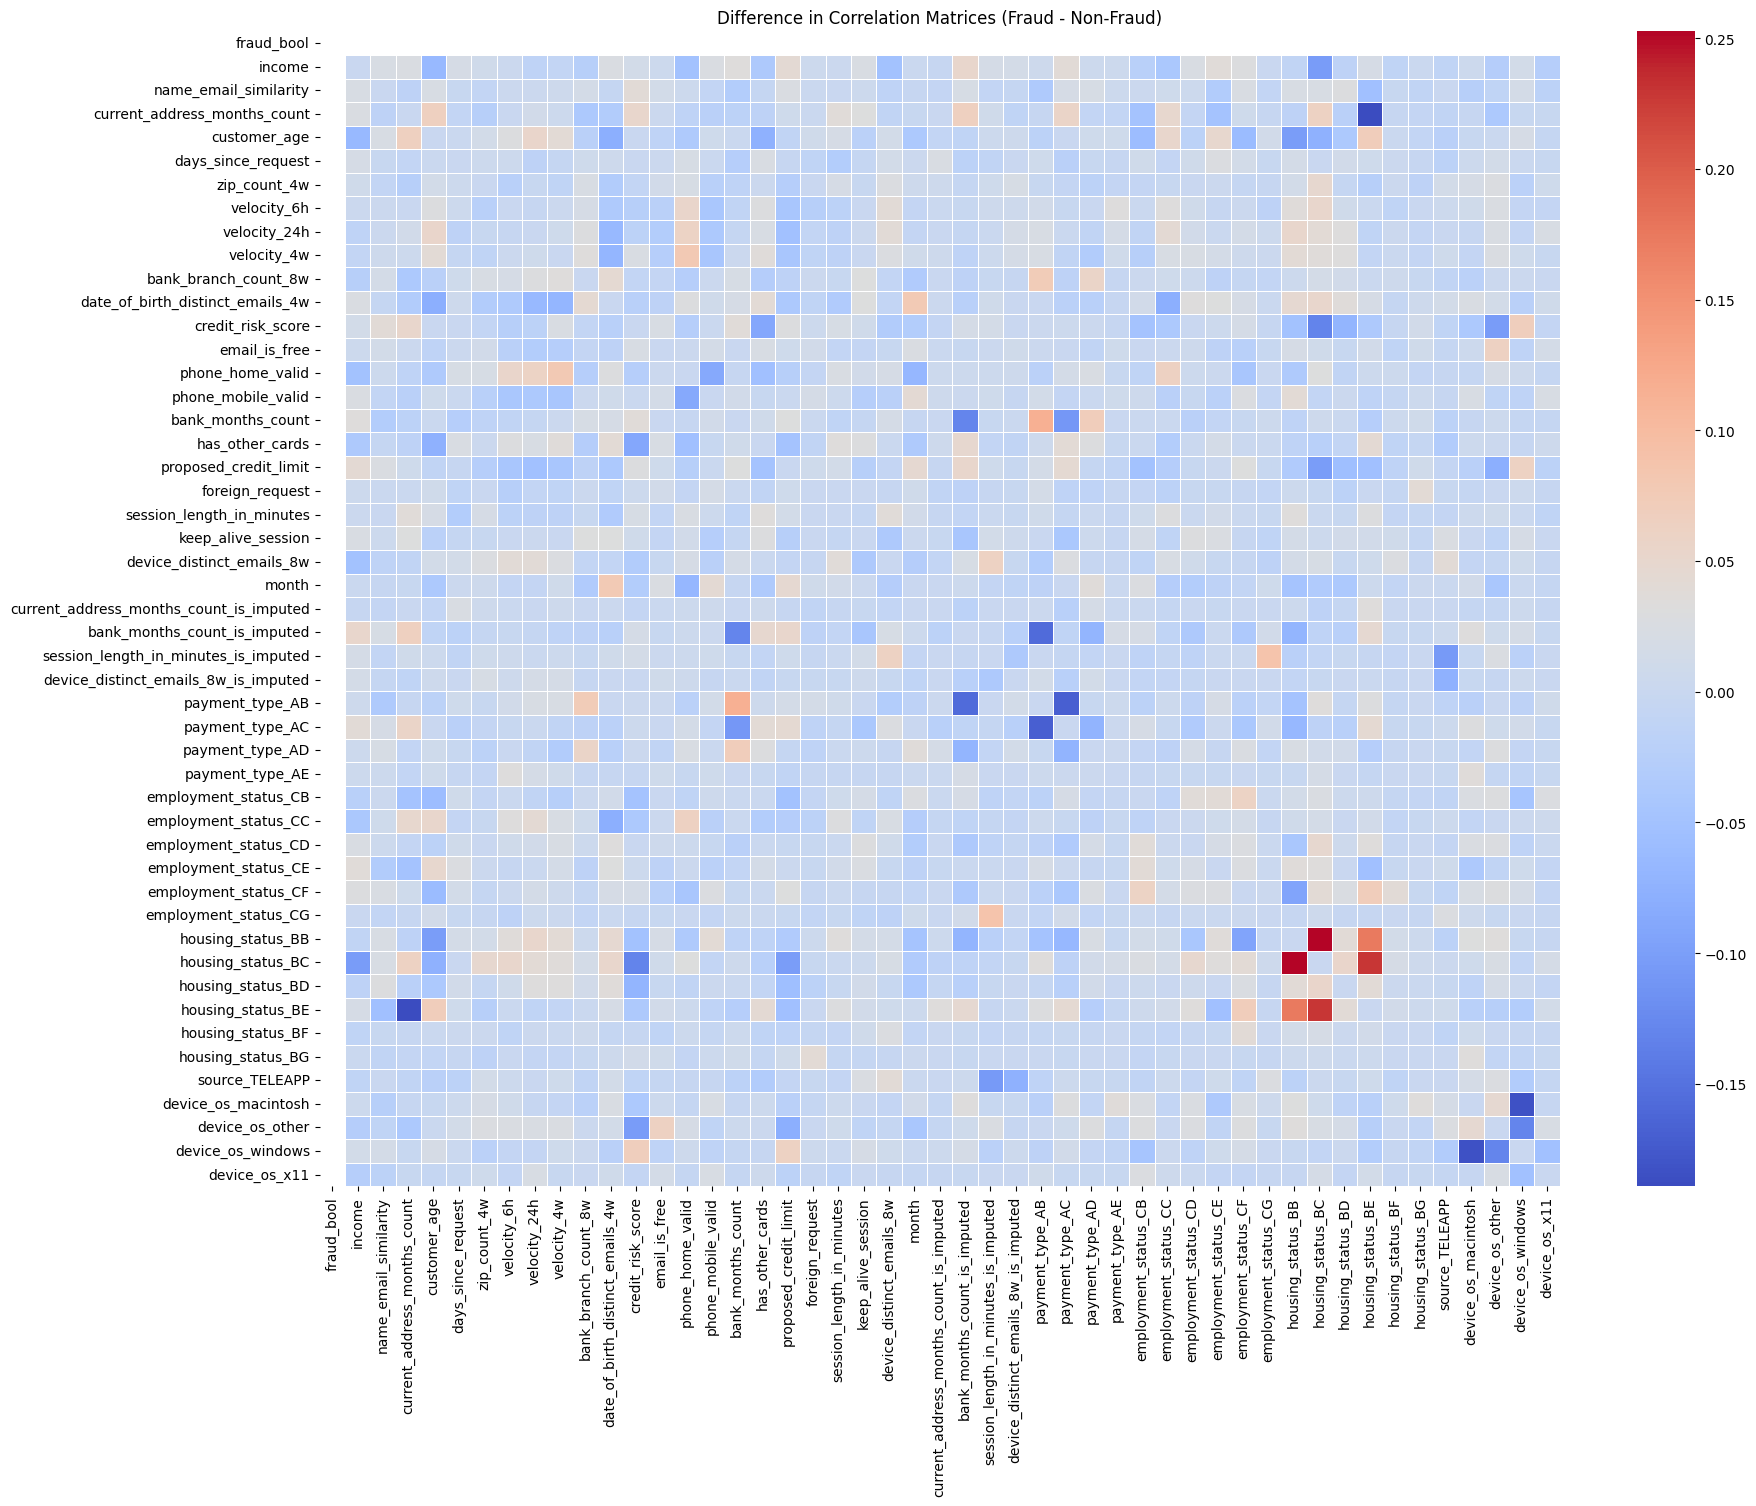

In [64]:
'''TABLE #5'''

data_for_analysis = cleaned_data.copy()

# Fraud Cases Only
fraud_corr = data_for_analysis[data_for_analysis['fraud_bool'] == 1].corr()

# Non-Fraud Cases Only
nonfraud_corr = data_for_analysis[data_for_analysis['fraud_bool'] == 0].corr()

# Step 4: Calculate the difference between the correlation matrices
correlation_difference = fraud_corr - nonfraud_corr

# Step 5: Plot Difference in Correlations
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_difference,cmap='coolwarm', linewidths=0.5)
plt.title('Difference in Correlation Matrices (Fraud - Non-Fraud)')
plt.show()



In [65]:
all_models = pd.read_csv('model_results.csv')

## Naive Approach

After cleaning the dataset and conducting EDA to see if there were any correlations or predictors that may stand out to help us work with our models, we found no standout features that significantly contributed to improving our understanding of the data. As a result, we decided to proceed to the model building. 

Our initial step was to establish baseline "control" models: if we did nothing to handle the imbalanced data, how would those models perform? Our naive approach served as a benchmark. 

We selected four models for our control group: logistic regression, K-nearest neighbors, decision tree, and a random forest of 100 trees. We investigated making more complex models, such as support vector machines or possibly any unsupervised models. However, our million rows and 30+ features made such approaches computationally prohibitive—the random forest model was the most complex in our control group.


Below is the results of the naive approach alongside an interpolated recall score if the model had a 5% false positive rate (FPR).

#### Control Models

In [66]:
# Print out the results of the naive approach
naive_approach = all_models[all_models['Sampling Method'] == 'Original Data'].drop(columns=['Sampling Method', 'Accuracy'])
naive_approach.drop(index=[20, 25], inplace=True)
print(naive_approach)

   Model                 Precision  Recall    F1-Score  ROC-AUC   FPR       Recall @5% FPR
0   Logistic Regression  0.447368   0.007665  0.015071  0.872193  0.000106  0.504959      
5   K-Nearest Neighbors  0.150000   0.001353  0.002681  0.660778  0.000086  0.294612      
10        Decision Tree  0.083089   0.102344  0.091717  0.544839  0.012665  0.136288      
15        Random Forest  0.428571   0.001353  0.002697  0.819742  0.000020  0.439317      


As expected, these initial models performed poorly regarding recall rates, though the false positive rates were surprisingly low for all of them, some approaching 0%. The only notable trend to take away from this is that last column: a higher FPR resulted in a higher recall rate, and seeing this trend later has caused us some trouble with our original 5% FPR restriction, leading us to scrap it. Balancing recall and FPR became a recurring issue throughout the project, as we aimed to maximize fraud detection while minimizing incorrect fraud predictions.

A trade-off between recall and FPR comes from the imbalanced nature of this dataset.  Increasing recall requires our model to be more aggressive in predicting fraud, which causes an increase in FPR. Fixing FPR at a low threshold forces our model to be more conservative, which creates an increase in missing actual fraudulent transactions, which is a failure in the model design.  

Having a high FPR might seem problematic, but in the case of fraud detection, it's better than having a lower recall rate. A false positive, which is a legitimate transaction being flagged as fraud, results in a negative customer experience. However, a false negative, a fraudulent transaction being labeled as legitimate, can result in financial losses for both the customer and the organization, which must then go through dispute resolution. For these reasons, we prioritize models with higher recall even at a cost of false postive rates as this approach aligns with our goals for fraud detection


## Imbalanced Data Handling

Going into this project, we knew that the only way to improve performance was to handle the imbalanced data. Fortunately, there's some techniques that we could incorporate into our models, as well as some specialized models meant for imbalanced data that we could use to try and improve performance.

### Sampling Techniques

For our project, we used 4 sampling techniques to attempt to improve performance on our imbalanced dataset: SMOTE, ADASYN, Random Undersampling, and a combination of SMOTE and Tomek's Links.

Three of the techniques we used involved oversampling: modifying the minority class and inflating the amount of data in the minority to match that of the majority.

* SMOTE, or Synthetic Minority Oversampling Technique, attempts to improve the performance of a model by generating new observations of the minority class. The new observations are generated by selecting a point, finding its nearest neighbor, and placing a point in between the two.
* ADASYN, or the Adaptive Synthetic sampling technique, is an upgrade on SMOTE that aims to synthesize data points that are deemed "harder to learn".
* The combination of SMOTE + Tomek's Links involves first using SMOTE to inflate the dataset and then the use of the Tomek's Links algorithm to undersample the dataset by selecting pairs of observations that are the nearest neighbors to each other but of differing classes.

One of our techniques solely relied on undersampling: modifying the majority class and pruning the amount of data in the majority to match that of the minority.

* Random undersampling involves randomly taking a subset of the majority equal to the size of the minority.

Applying these various techniques to our four starter models achieved better results compared to just using the original dataset, we also looked at additional models meant for imbalanced data and see how they compared.

### Imbalanced Models

For our project, we looked at 2 models that were specifically designed for imbalanced data: Balanced Forests and XGBoost

* Balanced Forests are similar to random forests, but instead of giving the whole dataset to each tree, a balanced forest undersamples the dataset and gives the result to each tree in the forest.
* XGBoost, or the Extreme Gradient Boost model, is a special kind of decision tree that uses gradient boosting and elastic regression to adjust itself after each iteration.

We ran each model (except XGBoost) with each imbalanced sampling technique to see how those models faired with a specific technique to see if a specific model performed better or worse with a specific technique. Included is a barplot of the recall rates and the FPR of each technique and the models they were performed on:

#### Models and their corresponding Recall and FPR by Sampling

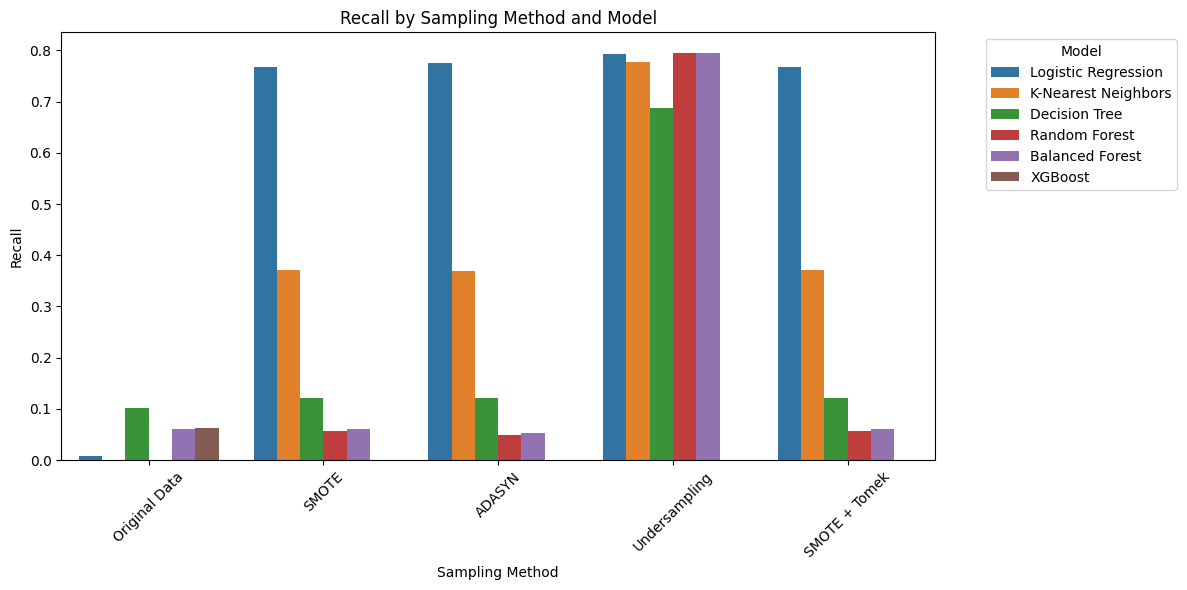

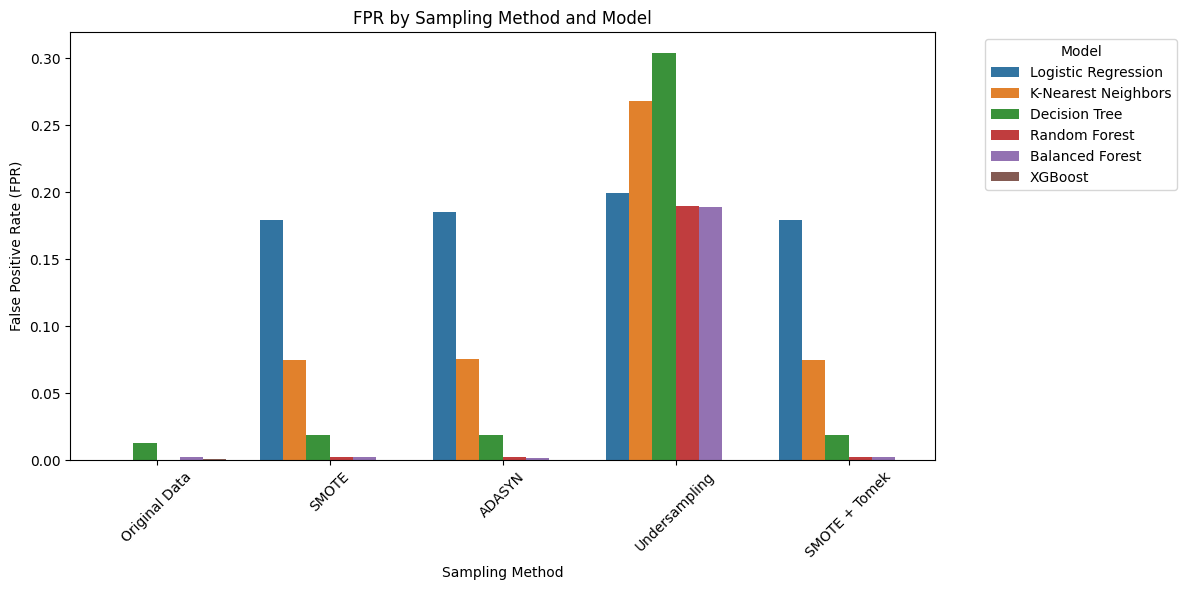

In [67]:
plt.figure(figsize=(12, 6))
sns.barplot(data=all_models, x='Sampling Method', y='Recall', hue='Model')
plt.title('Recall by Sampling Method and Model')
plt.xlabel('Sampling Method')
plt.ylabel('Recall')
plt.xticks(rotation=45)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Bar plot of FPR by Sampling Method and Model
plt.figure(figsize=(12, 6))
sns.barplot(data=all_models, x='Sampling Method', y='FPR', hue='Model')
plt.title('FPR by Sampling Method and Model')
plt.xlabel('Sampling Method')
plt.ylabel('False Positive Rate (FPR)')
plt.xticks(rotation=45)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Conclusion

Compiling all of the models we used and the best sampling technique used on them, we get this final table of results:

In [68]:
conc = all_models.iloc[all_models.groupby("Model")["Recall"].idxmax()].sort_values("Recall", ascending=False)
print(conc)

   Model                Sampling Method  Accuracy  Precision  Recall    F1-Score  ROC-AUC   FPR       Recall @5% FPR
18        Random Forest  Undersampling   0.810425  0.044971   0.795311  0.085129  0.879264  0.189406  0.486192      
23      Balanced Forest  Undersampling   0.810560  0.044956   0.794409  0.085096  0.878432  0.189259  0.478887      
3   Logistic Regression  Undersampling   0.800505  0.042717   0.793508  0.081070  0.872973  0.199417  0.504058      
8   K-Nearest Neighbors  Undersampling   0.732790  0.031534   0.777277  0.060608  0.816793  0.267709  0.358584      
13        Decision Tree  Undersampling   0.695915  0.024752   0.688007  0.047785  0.692005  0.303996  0.113160      
25              XGBoost  Original Data   0.988480  0.383152   0.063571  0.109049  0.884227  0.001148  0.523895      


The best sampling technique for our model turned out to be under-sampling. We initially expected more advanced techniques, such as SMOTE (synthetic minority oversampling techniques) or ADASYN (adaptive synthetic sampling), to perform better than under-sampling. The results from the graph shown above show that these techniques generally performed worse brackets except for logistic regressions, which remain consistent brackets.

This outcome is tied to the way our advanced sampling technique functions. Both methods rely on strong predictors or a combination of predictors that correlate highly with the minority class, which in this case is fraudulent activity. The covariance matrix and other exploratory data analysis showed that no single predictor or a combination of predictors can determine fraudulent activity. The synthetic data sets created by those advanced sampling techniques failed to improve our model's performance and, in some cases, performed no better or even worse than random chance.

Randomly reducing the majority class worked better because it created a more balanced data set by simplifying our models' tasks. By limiting the majority's class dominance, the model could better identify patterns in the minority class without being overwhelmed by the sheer volume of majority class data. Though straightforward, this approach not only proved to be more effective given the lack of strong fraud predictors in our data set but also reduced the computational intensiveness for our project. 


The best model performance was the random forest with the under-sampling technique. This, again, took us by surprise as we expected the balanced forest and XGBoost models to perform better due to them being made specifically to deal with imbalanced data. Looking at the results, XGBoost and the balanced forest did better than the random forest when using the original dataset. Still, when using under sampling, the balanced forest barely did worse than the random forest, which makes sense. A balanced forest *is* a random forest with built-in under-sampling. If this model were used, we could determine 79.5% of all fraudulent activity with an FPR of 18.9% before tuning. Even with all these models not being tuned, it would only increase performance slightly and be computationally intensive. 

But why does this all matter? Why did we choose the model with such high recall rate yet high FPR? As stated previously in the paper, in fraud detection, it's safer to go with more false positives that'll become inconveniences than to go with more false negatives that'll become money stolen. Our original idea was to try and find the best model and sampling technique while having the FPR less than 5%, but seeing that our best model and sampling technique, the random forest with undersampling, would have a recall rate of 48% if we kept the FPR at 5%, we decided to forgo this restriction as our vision of what the "best" model would be would ultimately not be the best model in the eyes of fraud detection.

Fraud detection is hard. There are many factors that play a role, and many of them could easily be legitimate in certain circumstances. In our project, we noted that there were no predictors that stood out as being more fraudulent than legitimate, so used all the predictors into our models and looked at how models would perform if every feature was used. We attempted feature engineering to see if there were any bins within predictors that stood out as fraudulent, but they were miniscule compared to everything else. We tried using correlation matrices to see if there were any relationships between predictors that stood out as being more fraudulent, but an overwhelming majority of them had little to no difference between fraudulence or legitimacy. We tried multiple models and sampling techniques with every factor, and with our current knowledge and expertise as well as with this challanges in this dataset, this was the best model we could create. 